## Issues

1. how to select a specific image?
1. how to determine a specific image type (when they are not labeled with correct map type)

In [4]:
# Next, we will load the files into pandas DataFrames:

import pandas as pd

# Load collections:

collections = pd.read_csv('nv-data/november_2022/statmaps_statisticmap.csv')

collections.head()

# Now, we load the statistical images, which require merging several tables.
#
# In order to merge `StatisticMap` to `Image`, we need the table `BaseStatisticMap`

image = pd.read_csv('nv-data/november_2022/statmaps_image.csv')
basecollectionitem = pd.read_csv('nv-data/november_2022/statmaps_basecollectionitem.csv')
statisticmap = pd.read_csv('nv-data/november_2022/statmaps_statisticmap.csv')

# `image` table is first merged to `basecollectionitem` using `basecollectionitem_ptr_id`:

image_merged = pd.merge(image, basecollectionitem, left_on='basecollectionitem_ptr_id', right_on='id')

# Next, the `statisticmap` table can be merged to `image` using `image_ptr_id', which corresponds to 'basecollectionitem_ptr_id'

statisticmap_merged = pd.merge(statisticmap, image_merged, left_on='image_ptr_id', right_on='basecollectionitem_ptr_id')

statisticmap_merged.head()

/tmp/ipykernel_844278/2193791942.py:7: DtypeWarning: Columns (4,5,7,15,17) have mixed types. Specify dtype option on import or set low_memory=False.
  collections = pd.read_csv('nv-data/november_2022/statmaps_statisticmap.csv')
/tmp/ipykernel_844278/2193791942.py:15: DtypeWarning: Columns (1,2,3,4,6,7,16,18,19,22,24) have mixed types. Specify dtype option on import or set low_memory=False.
  image = pd.read_csv('nv-data/november_2022/statmaps_image.csv')
/tmp/ipykernel_844278/2193791942.py:17: DtypeWarning: Columns (4,5,7,15,17) have mixed types. Specify dtype option on import or set low_memory=False.
  statisticmap = pd.read_csv('nv-data/november_2022/statmaps_statisticmap.csv')


,image_ptr_id,map_type,statistic_parameters,smoothness_fwhm,contrast_definition,contrast_definition_cogatlas,modality,cognitive_paradigm_cogatlas_id,ignore_file_warning,is_thresholded,...,tanner_stage,waist_hip_ratio,id,name,description,add_date,modify_date,collection_id,polymorphic_ctype_id,is_valid
0,31648,U,NaN,NaN,NaN,NaN,fMRI-BOLD,NaN,f,f,...,NaN,NaN,31648,IAPS_Subject_118_Image_9300.nii.gz,NaN,2016-11-07 07:46:11.896725+00,2018-06-30 05:54:51.405011+00,503,23,f
1,19014,R,NaN,NaN,NaN,NaN,fMRI-BOLD,trm_4c8a834779883,f,NaN,...,NaN,NaN,19014,changes_1,test picture from the life-kinetik study,2016-05-04 08:53:55.659069+00,2016-05-04 08:53:57.088053+00,1346,23,t
2,23283,Other,NaN,NaN,NaN,NaN,NaN,NaN,f,t,...,NaN,NaN,23283,DTI AntiGroupMap,FSL4.1,2016-06-12 20:40:51.151294+00,2018-06-30 05:07:36.969385+00,1448,23,f
3,23287,Other,NaN,NaN,NaN,NaN,NaN,NaN,f,t,...,NaN,NaN,23287,DTI Future,FSL4.1,2016-06-12 20:40:54.295836+00,2018-06-30 05:07:29.845185+00,1448,23,f
4,44933,T,NaN,NaN,NaN,NaN,fMRI-BOLD,NaN,f,f,...,NaN,NaN,44933,subj21 dist intensity3,NaN,2017-04-21 19:12:37.490755+00,2017-07-26 11:56:13.335153+00,2448,23,t


<Axes: xlabel='modality', ylabel='Count'>

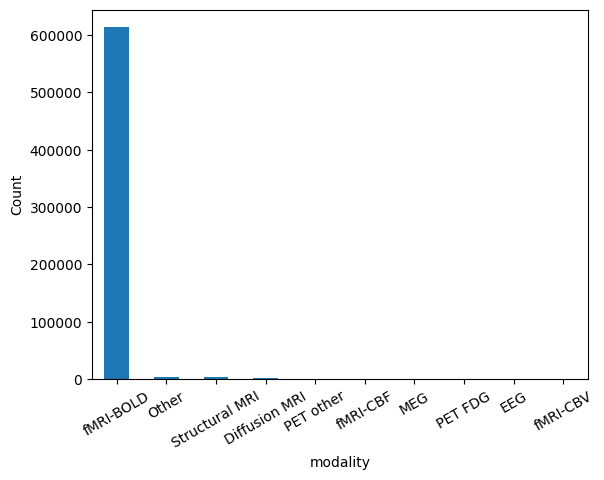

In [2]:
# only want fMRI-BOLD images
statisticmap_merged['modality'].value_counts().plot(kind='bar', xlabel='modality', ylabel='Count', rot=30)

In [3]:
fmri_statmaps = statisticmap_merged.loc[statisticmap_merged["modality"] == "fMRI-BOLD"]

In [4]:
# filterempty cogatlas ids
cogatlas_statmaps = fmri_statmaps.loc[~fmri_statmaps["cognitive_paradigm_cogatlas_id"].isna()]

In [5]:
# display cog-atlas ids
# most common terms (each collection gets one
def mode_tie_break(df):
    result = pd.Series.mode(df)
    if len(result) > 1:
        return result[0]
    return result
    
collection_terms = cogatlas_statmaps.groupby("collection_id")["cognitive_paradigm_cogatlas_id"].agg(mode_tie_break).value_counts()


In [6]:
collection_terms

cognitive_paradigm_cogatlas_id
trm_4c8a834779883    397
trm_54e69c642d89b    173
trm_5667441c338a7    137
trm_550b557e5f90e     80
trm_4f24126c22011     71
                    ... 
trm_55a6a52537c2b      1
trm_52713c85c0bd2      1
tsk_4a57abb949858      1
tsk_4a57abb949f21      1
trm_4d54b2cc0f943      1
Name: count, Length: 360, dtype: int64

In [7]:
# more than 10 maps
enough_maps = collection_terms[collection_terms >= 10]

In [10]:
# cognitive atlas terms
import requests
def get_task_name(task_id):
    cog_atlas_template_url = f"http://cognitiveatlas.org/api/v-alpha/task?id={task_id}"
    resp = requests.get(cog_atlas_template_url)
    return resp.json()["name"]

collection_terms_df = pd.DataFrame(enough_maps)
cogatlas_names = collection_terms_df.index.map(get_task_name)
collection_terms_df["cogatlas_name"] = cogatlas_names

In [11]:
collection_terms_df

,count,cogatlas_name
cognitive_paradigm_cogatlas_id,,
trm_4c8a834779883,397,rest eyes open
trm_54e69c642d89b,173,rest eyes closed
trm_5667441c338a7,137,2nd-order rule acquisition
trm_550b557e5f90e,80,social cognition (theory of mind) fMRI task pa...
trm_4f24126c22011,71,abstract/concrete task
trm_5667451917a34,67,2-stage decision task
trm_4cacee4a1d875,60,mixed gambles task
trm_550b5b066d37b,56,emotion processing fMRI task paradigm
trm_550b54a8b30f4,55,language processing fMRI task paradigm


In [12]:
for term in collection_terms_df["cogatlas_name"].values:
    print(term)

rest eyes open
rest eyes closed
2nd-order rule acquisition
social cognition (theory of mind) fMRI task paradigm
abstract/concrete task
2-stage decision task
mixed gambles task
emotion processing fMRI task paradigm
language processing fMRI task paradigm
monetary incentive delay task
passive viewing
social judgment task
Food viewing (passive)
go/no-go task
movie watching task
social decision-making task
film viewing
balloon analogue risk task
emotional regulation task
phasic pain stimulation
aberrant behavior checklist - community
gambling task
working memory fMRI task paradigm
n-back task
Adult ADHD Clinical Diagnostic Scale
problem solving task
audio narrative
face matching task
motor fMRI task paradigm
action observation task
pain monitor/discrimination task
theory of mind task
pavlovian conditioning task
Emotion Regulation Task
Other evaluation task
Emotion Recognition Task
abstract/concrete judgment: bilingual
mental imagery task
semantic task
choice task between risky and non-risky

In [13]:
cogatlas_statmaps['map_type'].unique()

array(['R', 'Z', 'M', 'U', 'T', 'P', 'Other', 'F', 'Pa', 'X2', 'A', 'IP',
       'V'], dtype=object)

In [14]:
task = "tsk_4a57abb949bcd" # n-back task
all_task_maps = cogatlas_statmaps.query(
    f'cognitive_paradigm_cogatlas_id == "{task}" & analysis_level == "G" & is_thresholded == "f" & (map_type == "Z" | map_type == "Other" | map_type == "T" | map_type == "U" | map_type == "V" | map_type == "P" | map_type == "1P")'
)
all_task_maps.head()

,image_ptr_id,map_type,statistic_parameters,smoothness_fwhm,contrast_definition,contrast_definition_cogatlas,modality,cognitive_paradigm_cogatlas_id,ignore_file_warning,is_thresholded,...,tanner_stage,waist_hip_ratio,id,name,description,add_date,modify_date,collection_id,polymorphic_ctype_id,is_valid
2898,29421,Other,NaN,NaN,NaN,NaN,fMRI-BOLD,tsk_4a57abb949bcd,f,f,...,NaN,NaN,29421,between drift,FreeSurfer matlab ...,2016-10-25 03:05:32.337686+00,2018-06-30 05:37:53.092427+00,1941,23,t
2899,29423,Other,NaN,NaN,NaN,NaN,fMRI-BOLD,tsk_4a57abb949bcd,f,f,...,NaN,NaN,29423,between nondecision,FreeSurfer matlab ...,2016-10-25 03:05:33.281786+00,2018-06-30 05:37:50.202306+00,1941,23,t
2930,29424,Other,NaN,NaN,NaN,NaN,fMRI-BOLD,tsk_4a57abb949bcd,f,f,...,NaN,NaN,29424,between pupil,FreeSurfer matlab ...,2016-10-25 03:05:33.769713+00,2018-06-30 05:37:47.190355+00,1941,23,t
4674,31932,Z,NaN,6.0,NaN,NaN,fMRI-BOLD,tsk_4a57abb949bcd,f,f,...,NaN,NaN,31932,0back>1back,P1301 Main Effects 0 back >1 back,2016-11-07 12:35:37.313761+00,2016-11-07 12:35:46.37493+00,1966,23,t
4726,31933,Z,NaN,6.0,NaN,NaN,fMRI-BOLD,tsk_4a57abb949bcd,f,f,...,NaN,NaN,31933,1back>0back,P1301 Interaction analysis (GA). 1 back > 0 back,2016-11-07 12:37:34.615108+00,2016-11-07 12:58:01.631041+00,1966,23,t


In [15]:
all_task_maps.loc[all_task_maps["map_type"] == "T"]

,image_ptr_id,map_type,statistic_parameters,smoothness_fwhm,contrast_definition,contrast_definition_cogatlas,modality,cognitive_paradigm_cogatlas_id,ignore_file_warning,is_thresholded,...,tanner_stage,waist_hip_ratio,id,name,description,add_date,modify_date,collection_id,polymorphic_ctype_id,is_valid
5800,45487,T,NaN,NaN,1-back vs categorization control task,NaN,fMRI-BOLD,tsk_4a57abb949bcd,f,f,...,NaN,NaN,45487,Regions that showed significant task-related c...,NaN,2017-05-02 23:15:49.552121+00,2018-06-30 07:53:15.03325+00,2474,23,t
31318,45486,T,NaN,NaN,1-back minus categorization control task,NaN,fMRI-BOLD,tsk_4a57abb949bcd,f,f,...,NaN,NaN,45486,Regions that showed significant task modulatio...,NaN,2017-05-02 23:13:22.905188+00,2018-06-30 07:53:18.318212+00,2474,23,t
33778,50291,T,NaN,NaN,2-back minus 0-back,NaN,fMRI-BOLD,tsk_4a57abb949bcd,f,f,...,NaN,NaN,50291,t-value contrast 2-back minus 0-back,One-sample t-test describing the deviation of ...,2017-06-26 10:10:58.919731+00,2018-06-30 08:24:21.308572+00,2621,23,t
37249,57464,T,NaN,NaN,NaN,NaN,fMRI-BOLD,tsk_4a57abb949bcd,f,f,...,NaN,NaN,57464,Exp2_Body_localiser_Bodies>Cars,NaN,2017-11-23 14:08:09.60129+00,2018-06-30 08:35:20.348554+00,3191,23,t
37250,57463,T,NaN,NaN,NaN,NaN,fMRI-BOLD,tsk_4a57abb949bcd,f,f,...,NaN,NaN,57463,Exp1_PPI_rTPJSeed_Obese>Slim,NaN,2017-11-23 14:01:39.174681+00,2018-06-30 08:35:22.048569+00,3191,23,t
37252,57462,T,NaN,NaN,NaN,NaN,fMRI-BOLD,tsk_4a57abb949bcd,f,f,...,NaN,NaN,57462,Exp1_PPI_rTPSeed_Obese>Slim,NaN,2017-11-23 14:00:30.338777+00,2018-06-30 08:35:23.567177+00,3191,23,t
37254,57461,T,NaN,NaN,NaN,NaN,fMRI-BOLD,tsk_4a57abb949bcd,f,f,...,NaN,NaN,57461,Exp1_PPI_rFBASeed_Obese>Slim,NaN,2017-11-23 13:59:24.914029+00,2018-06-30 08:35:24.648386+00,3191,23,t
37256,57460,T,NaN,NaN,NaN,NaN,fMRI-BOLD,tsk_4a57abb949bcd,f,f,...,NaN,NaN,57460,Exp1_PPI_rEBASeed_Obese>Slim,NaN,2017-11-23 13:57:50.396243+00,2018-06-30 08:35:26.074493+00,3191,23,t
37257,57459,T,NaN,NaN,NaN,NaN,fMRI-BOLD,tsk_4a57abb949bcd,f,f,...,NaN,NaN,57459,Exp1_PPI_PrecuneusSeed_Obese>Slim,NaN,2017-11-23 13:56:48.781413+00,2018-06-30 08:35:27.085332+00,3191,23,t
37258,57458,T,NaN,NaN,NaN,NaN,fMRI-BOLD,tsk_4a57abb949bcd,f,f,...,NaN,NaN,57458,Exp1_PPI_mPFCSeed_Obese>Slim,NaN,2017-11-23 13:55:22.748936+00,2018-06-30 08:35:28.563543+00,3191,23,t


In [16]:
all_task_maps.loc[all_task_maps["map_type"] == "Other"][["name", "description", "number_of_subjects", "file", "figure", "thumbnail"]]

,name,description,number_of_subjects,file,figure,thumbnail
2898,between drift,FreeSurfer matlab ...,NaN,images/1941/between_drift.nii.gz,NaN,images/1941/glass_brain_29421_1.jpg
2899,between nondecision,FreeSurfer matlab ...,NaN,images/1941/between_nondecision.nii.gz,NaN,images/1941/glass_brain_29423_1.jpg
2930,between pupil,FreeSurfer matlab ...,NaN,images/1941/between_pupil.nii.gz,NaN,images/1941/glass_brain_29424_1.jpg
18367,Scanner1 2back 0back ST EPI,FSL5.0,14.0,images/1922/Scanner1_2back-0back_ST-EPI.nii.gz,8,images/1922/glass_brain_29310.jpg
18660,Scanner2 2back 0back MB2,FSL5.0,14.0,images/1922/Scanner2_2back-0back_MB2.nii.gz,8,images/1922/glass_brain_29326.jpg
18661,Scanner2 2back 0back ST EPI,FSL5.0,14.0,images/1922/Scanner2_2back-0back_ST-EPI.nii.gz,8,images/1922/glass_brain_29328.jpg
26521,Scanner1 2back 0back MB2,FSL5.0,14.0,images/1922/Scanner1_2back-0back_MB2.nii.gz,8,images/1922/glass_brain_29308.jpg
26662,Scanner1 2back 0back MB3,FSL5.0,14.0,images/1922/Scanner1_2back-0back_MB3.nii.gz,8,images/1922/glass_brain_29309.jpg
26985,Scanner2 2back 0back MB3,FSL5.0,14.0,images/1922/Scanner2_2back-0back_MB3.nii.gz,8,images/1922/glass_brain_29327.jpg
90800,task nback zstat 2back vs 1back,FSL5.0,36.0,images/4623/task-nback_zstat_2back_vs_1back.ni...,NaN,images/4623/glass_brain_109901.jpg


In [17]:
all_task_maps[all_task_maps['map_type'] == "T"][["name", "description", "collection_id", "image_ptr_id"]]

,name,description,collection_id,image_ptr_id
5800,Regions that showed significant task-related c...,NaN,2474,45487
31318,Regions that showed significant task modulatio...,NaN,2474,45486
33778,t-value contrast 2-back minus 0-back,One-sample t-test describing the deviation of ...,2621,50291
37249,Exp2_Body_localiser_Bodies>Cars,NaN,3191,57464
37250,Exp1_PPI_rTPJSeed_Obese>Slim,NaN,3191,57463
37252,Exp1_PPI_rTPSeed_Obese>Slim,NaN,3191,57462
37254,Exp1_PPI_rFBASeed_Obese>Slim,NaN,3191,57461
37256,Exp1_PPI_rEBASeed_Obese>Slim,NaN,3191,57460
37257,Exp1_PPI_PrecuneusSeed_Obese>Slim,NaN,3191,57459
37258,Exp1_PPI_mPFCSeed_Obese>Slim,NaN,3191,57458


In [19]:
ideal_images = [
    {"id": "29310", "map_type": "Z"},
    {"id": "109901", "map_type": "Z"},
    {"id": "787480", "map_type": "T"},
    {"id": "31933", "map_type": "Z"},
    {"id": "42807", "map_type": "Z"},
    {"id": "50291", "map_type": "T"},
]
    

In [20]:
import nibabel as nib
from nimare.meta.ibma import Stouffers
from nimare.dataset import Dataset

In [21]:
# get the image data for the ideal images
import os
import requests

def download_images(image_ids, output_directory):
    image_info_list = []

    # Ensure the output directory exists
    os.makedirs(output_directory, exist_ok=True)

    for image_id in image_ids:
        # Construct the NeuroVault API URL for image info
        image_info_url = f"https://neurovault.org/api/images/{image_id}/"

        try:
            # Make a GET request to fetch image info
            response = requests.get(image_info_url)

            if response.status_code == 200:
                image_info = response.json()

                # Download the image file
                image_url = image_info['file']
                image_filename = os.path.basename(image_url)
                image_path = os.path.join(output_directory, image_filename)

                # Download the image
                response = requests.get(image_url)
                with open(image_path, 'wb') as image_file:
                    image_file.write(response.content)

                # Append image info to the list
                image_info_list.append(image_info)

            else:
                print(f"Failed to retrieve image info for ID {image_id}")

        except Exception as e:
            print(f"An error occurred while processing image ID {image_id}: {str(e)}")

    return image_info_list

# Example usage:
image_ids = [im["id"] for im in ideal_images]  # Replace with your list of image IDs
output_directory = "ideal_images"  # Replace with your desired output directory

image_info = download_images(image_ids, output_directory)

In [22]:
image_info[4]["number_of_subjects"]

21

In [23]:
def derive_map_type(image_info):
    base_image_info = []
    for ii in image_info:
        if ii["map_type"] == "other":
            if ii["name"] == "Scanner1 2back 0back ST EPI":
                map_type = "Z map"
            elif "zstat" in ii["name"]:
                map_type = "Z map"
            elif "T_" in ii["description"]:
                map_type = "T map"
            else:
                raise ValueError
        else:
            map_type = ii["map_type"]
        base_image_info.append(
            {"id": ii["id"], "derived_map_type": map_type, "sample_size": ii["number_of_subjects"], "fname": os.path.basename(ii["file"])}
        )
    return base_image_info
        

necessary_image_info = derive_map_type(image_info)
necessary_image_info

[{'id': 29310,
  'derived_map_type': 'Z map',
  'sample_size': 14,
  'fname': 'Scanner1_2back-0back_ST-EPI.nii.gz'},
 {'id': 109901,
  'derived_map_type': 'Z map',
  'sample_size': 36,
  'fname': 'task-nback_zstat_2back_vs_1back.nii.gz'},
 {'id': 787480,
  'derived_map_type': 'T map',
  'sample_size': 49,
  'fname': 'CTR_NB_snpmT.nii.gz'},
 {'id': 31933,
  'derived_map_type': 'Z map',
  'sample_size': 29,
  'fname': 'zstat1_1.nii.gz'},
 {'id': 42807,
  'derived_map_type': 'Z map',
  'sample_size': 21,
  'fname': 'NBACK_tACS_OFF_pos.nii.gz'},
 {'id': 50291,
  'derived_map_type': 'T map',
  'sample_size': 1369,
  'fname': 'Egli_et_al_2017_Tval2bVs0bContrast.nii.gz'}]

In [24]:
from nimare.io import DEFAULT_MAP_TYPE_CONVERSION
def convert_to_nimare_dataset(necessary_image_info, contrast_name, img_dir):
    dataset_dict = {}
    for ii in necessary_image_info:
        dataset_dict[f"study-{ii['id']}"] = {"contrasts": {contrast_name: {"metadata": {"sample_sizes": None}, "images": {DEFAULT_MAP_TYPE_CONVERSION[ii["derived_map_type"]]: None}}}}
        (
        dataset_dict[f"study-{ii['id']}"]["contrasts"][contrast_name]["images"][
                            DEFAULT_MAP_TYPE_CONVERSION[ii["derived_map_type"]]
                        ]
                    ) = "/".join([img_dir, ii["fname"]])
        dataset_dict[f"study-{ii['id']}"]["contrasts"][contrast_name]["metadata"]["sample_sizes"] = [ii["sample_size"]]

    return Dataset(dataset_dict)

dset = convert_to_nimare_dataset(necessary_image_info, "n-back", os.path.abspath("./ideal_images"))

INFO:nimare.utils:Shared path detected: '/home/jdkent/projects/NVImageBasedMetaAnalysis/nv-data/ideal_images/'


In [25]:
from nimare.transforms import ImageTransformer

z_dset = ImageTransformer("z").transform(dset)
# Stouffers(resample=True).fit(dset)

/home/jdkent/projects/NVImageBasedMetaAnalysis/nv-data/.nvibma/lib/python3.8/site-packages/nilearn/maskers/nifti_masker.py:98: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/home/jdkent/projects/NVImageBasedMetaAnalysis/nv-data/.nvibma/lib/python3.8/site-packages/nilearn/image/resampling.py:673: RuntimeWarning: NaNs or infinite values are present in the data passed to resample. This is a bad thing as they make resampling ill-defined and much slower.
  _resample_one_img(
/home/jdkent/projects/NVImageBasedMetaAnalysis/nv-data/.nvibma/lib/python3.8/site-packages/nilearn/maskers/nifti_masker.py:98: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the

In [26]:
result = Stouffers(resample=True).fit(dset)

INFO:nimare.dataset:Retaining 4/6 studies


In [27]:
import numpy as np
np.isnan(result.maps.get("z")).sum()

64122

In [28]:
result.maps.get("z").shape

(228483,)

In [29]:
from nilearn.plotting import plot_stat_map


/home/jdkent/projects/NVImageBasedMetaAnalysis/nv-data/.nvibma/lib/python3.8/site-packages/nilearn/_utils/niimg.py:62: UserWarning: Non-finite values detected. These values will be replaced with zeros.
  warn(


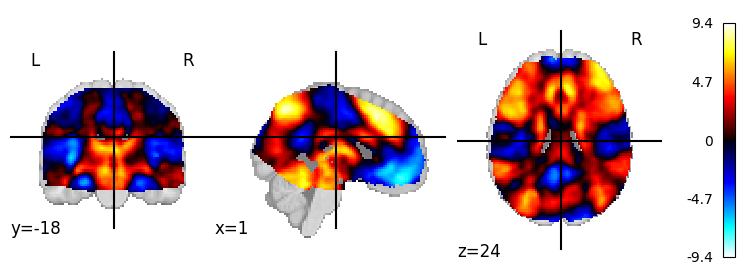

In [31]:
plot_stat_map(result.get_map("z"))